# Lyrics cleaning and analysis

### Find instructions here for nltk use (https://github.com/johnwmillr/LyricsGenius/blob/master/README.md)

In [1]:
# #Install lyrics genius module
# !pip install lyricsgenius

In [2]:
# ## Natural Language Toolkit (NLTK) is a Python package for natural language processing
# ## Install nltk module (for info: https://www.nltk.org/data.html) *takes a while to download*
# !pip install nltk

In [3]:
#Import module and config with token

#for API calls
import requests
import pandas as pd
from pprint import pprint

#for genius.com
import lyricsgenius
from config import genius_token
genius = lyricsgenius.Genius(genius_token)

# #for nlkt (remove stop words)    ---> all available datasets/models:CORPORA: http://www.nltk.org/nltk_data/
# import nltk
# nltk.download("stopwords")   #can install the “popular” subset of NLTK data, stopwords is included
from nltk.corpus import stopwords 

# for punctuation, import string library function  
import string  

#for plotting
import matplotlib.pyplot as plt
import seaborn as sns

#for stats
import scipy.stats as stats


In [4]:
#RUN WHEN LIST OF SONGS IS AVAILABLE

#Open file with songs from top populated eras
song_with_lyrics_df=pd.read_csv("csv/song_with_lyrics.csv")

# #Drop weird column created for don't know what reason
weird_columns=["Unnamed: 0", "Unnamed: 0.1", "Unnamed: 0.1.1"]
song_list_df=song_with_lyrics_df.drop(weird_columns, axis=1)


song_list_df.head(15)

,Rank,Song Name,Artist,Duration,Album,Lyrics,Year,bins
0,2,The Scientist,Coldplay,309,A Rush of Blood to the Head,"[Verse 1]\nCome up to meet you, tell you I'm s...",2002,2000s
1,3,Yellow,Coldplay,267,Parachutes,[Verse 1: Chris Martin]\nLook at the stars\nLo...,2000,2000s
2,4,Fix You,Coldplay,294,X&Y,[Verse 1: Chris Martin]\nWhen you try your bes...,2005,2000s
3,5,Chasing Cars,Snow Patrol,0,Eyes Open,[Verse 1]\nWe'll do it all\nEverything\nOn our...,2006,2000s
4,7,I'm Yours,Jason Mraz,242,I'm Yours,"[Verse 1]\nWell, you done done me, and you bet...",2008,2000s
5,8,I Will Follow You Into The Dark,Death Cab for Cutie,0,Plans,"[Verse 1]\nLove of mine, someday you will die\...",2006,2000s
6,9,How to Save a Life,The Fray,290,How to Save a Life,"[Verse 1]\nStep one, you say we need to talk\n...",2005,2000s
7,11,She Will Be Loved,Maroon 5,379,Songs About Jane,[Verse 1]\nBeauty queen of only eighteen\nShe ...,2002,2000s
8,12,Such Great Heights,The Postal Service,262,Give Up,[Verse 1]\nI am thinking it's a sign\nThat the...,2003,2000s
9,13,Skinny Love,Bon Iver,239,"For Emma, Forever Ago","[Verse 1]\nCome on, skinny love, just last the...",2007,2000s


In [5]:
#example of lyrics
song_list_df["Lyrics"][0]

"[Verse 1]\nCome up to meet you, tell you I'm sorry\nYou don't know how lovely you are\nI had to find you, tell you I need you\nTell you I set you apart\nTell me your secrets, and ask me your questions\nOh, let's go back to the start\nRunning in circles, coming up tails\nHeads on a science apart\n\n[Chorus]\nNobody said it was easy\nIt's such a shame for us to part\nNobody said it was easy\nNo one ever said it would be this hard\nOh, take me back to the start\n\n[Verse 2]\nI was just guessing at numbers and figures\nPulling the puzzles apart\nQuestions of science, science and progress\nDo not speak as loud as my heart\nTell me you love me, come back and haunt me\nOh, and I rush to the start\nRunning in circles, chasing our tails\nComing back as we are\n\n[Chorus]\nNobody said it was easy\nOh it's such a shame for us to part\nNobody said it was easy\nNo one ever said it would be so hard\nI'm going back to the start\n\n[Outro]\nOh-ooh ooh-ooh-ooh-ooh\nAah-ooh ooh-ooh-ooh-ooh\nOh-ooh ooh-

In [6]:
#Check for duplicates in the list of songs
duplicates=song_list_df.duplicated(subset=["Song Name", "Artist"], keep=False)
song_list_df[duplicates]

,Rank,Song Name,Artist,Duration,Album,Lyrics,Year,bins


## Cleaning lyrics
* stop words (a, about, above, after, again, against, all....)
* punctuation characters (. ; : [] ? ...)
* words related to song structure (intro, chorus, verse)
* numbers

In [7]:
#Split lyrics into words, create a new df

#punctuation= [',', '.', ';', ':', '[', ']', '?', '!', '(', ')', '"', '%', "&", "-", "--"]  #old punctuation
punctuation=list(string.punctuation)

#(for info: https://www.geeksforgeeks.org/removing-stop-words-nltk-python/)
stop_words_original= set(stopwords.words('english')) 
words_we_want=['against',"i",'he','her','hers','herself','him','himself','his','me','my','myself', "she",\
               'you', "you'd","you'll","you're","you've",'your','yours','yourself','yourselves']
stop_words_clean= [j for j in stop_words_original if not j in words_we_want]

#possible verse number (as strings)
numbers=[str(n) for n in range(100)]

#possible song structure terms and artist names
song_structure_words=["intro", "verse", "chorus", "bridge", "outro", "hook"]  #"chris", "martin", 

#list of total words, unique words (arrays) and unique_word_counts (series)
tot_words_list=[]            #list of total number of words per song
unique_words_list=[]         #list of unique words per song
unique_words_count_list=[]   #list of count of unique words per song


for index, row in song_list_df.iterrows():
    
    #Store song lyrics in a variable
    song_lyrics=song_list_df["Lyrics"][index]

    #Before splitting lyrics into words, remove punctation characters
    song_lyrics_clean= song_lyrics

    for x in punctuation:
        if not x == "'":
            song_lyrics_clean=song_lyrics_clean.replace(x,"")

    #Split string into list of words
    words_list= song_lyrics_clean.split() 

    #Make df of lowercase words (stop words are all lowercase)
    words_list_lower=[words_list[x].lower() for x in range(len(words_list))]

    #Remove stop words such as “the”, “a”, “an”, “in” 
    filtered_1=[k for k in words_list_lower if not k in stop_words_clean]
    
    #remove possible verse number (as strings)
    filtered_2=[k for k in filtered_1 if not k in numbers] 

    #remove song structure words     
    filtered_lyrics_index=[k for k in filtered_2 if not k in song_structure_words] 
    
    #Create a df for lyrics analysis
    lyrics_index_df=pd.DataFrame()
 
    #Save song_lyrics_clean to a new dataframe
    lyrics_index_df[index]=filtered_lyrics_index
    
    #Number of words
    tot_words=len(lyrics_index_df[index])
    tot_words_list.append(tot_words)
    
    #Unique words
    unique_words=lyrics_index_df[index].unique()
    unique_words_list.append(unique_words)
    
    #Count of Unique words
    unique_words_count=lyrics_index_df[index].value_counts()
    unique_words_count_list.append(unique_words_count)    
    
    
#     #Rename column and export to csv as lyrics_index.csv
#     column_name= f'{song_list_df["Song Name"][index]}_{song_list_df["Artist"][index]}'
#     lyrics_index_df=lyrics_index_df.rename(columns={index: column_name})
#     lyrics_index_df.to_csv(f'Lyrics/lyrics_{index}_df.csv')

lyrics_index_df

,1109
0,love
1,tragic
2,love
3,bold
4,you
...,...
104,handle
105,life
106,i
107,can't


In [8]:
#list of total words for each song
tot_words_list

[125,
 136,
 133,
 112,
 280,
 132,
 228,
 200,
 139,
 125,
 154,
 182,
 560,
 238,
 170,
 325,
 127,
 212,
 65,
 86,
 176,
 154,
 179,
 141,
 73,
 125,
 272,
 312,
 90,
 163,
 196,
 59,
 74,
 99,
 80,
 282,
 210,
 217,
 139,
 103,
 160,
 146,
 123,
 279,
 60,
 123,
 160,
 98,
 70,
 172,
 117,
 215,
 181,
 173,
 197,
 138,
 234,
 401,
 205,
 227,
 107,
 135,
 362,
 127,
 216,
 297,
 218,
 122,
 184,
 176,
 252,
 130,
 100,
 112,
 179,
 302,
 138,
 348,
 167,
 60,
 397,
 405,
 327,
 296,
 200,
 129,
 175,
 92,
 94,
 176,
 101,
 128,
 173,
 119,
 165,
 166,
 89,
 174,
 248,
 195,
 131,
 87,
 167,
 532,
 140,
 82,
 136,
 119,
 127,
 545,
 203,
 170,
 113,
 131,
 73,
 101,
 566,
 112,
 100,
 195,
 192,
 156,
 85,
 159,
 138,
 158,
 217,
 98,
 270,
 123,
 159,
 167,
 193,
 134,
 433,
 57,
 190,
 165,
 236,
 160,
 212,
 204,
 85,
 111,
 201,
 98,
 302,
 285,
 278,
 146,
 124,
 169,
 109,
 328,
 48,
 160,
 139,
 201,
 137,
 167,
 119,
 164,
 126,
 86,
 197,
 75,
 119,
 203,
 114,
 190,
 155,


In [9]:
#list of unique words for each song
unique_words_list

[array(['come', 'meet', 'you', 'tell', "i'm", 'sorry', 'know', 'lovely',
        'i', 'find', 'need', 'set', 'apart', 'me', 'your', 'secrets',
        'ask', 'questions', 'oh', "let's", 'go', 'back', 'start',
        'running', 'circles', 'coming', 'tails', 'heads', 'science',
        'nobody', 'said', 'easy', 'shame', 'us', 'part', 'one', 'ever',
        'would', 'hard', 'take', 'guessing', 'numbers', 'figures',
        'pulling', 'puzzles', 'progress', 'speak', 'loud', 'my', 'heart',
        'love', 'haunt', 'rush', 'chasing', 'going', 'ohooh',
        'oohoohoohooh', 'aahooh'], dtype=object),
 array(['chris', 'martin', 'look', 'stars', 'shine', 'you', 'everything',
        'yeah', 'yellow', 'i', 'came', 'along', 'wrote', 'song', 'things',
        'called', 'took', 'my', 'turn', 'oh', 'thing', 'done', 'jonny',
        'aah', 'your', 'skin', 'bones', 'ooh', 'something', 'beautiful',
        'know', 'love', 'swam', 'across', 'jumped', "'cause", 'drew',
        'line', "i'd", 'bleed', '

In [10]:
#list of unique words counts for each song
unique_words_count_list

[you             10
 me               6
 said             6
 tell             5
 i                5
 back             5
 start            4
 oh               4
 easy             4
 nobody           4
 oohoohoohooh     4
 apart            3
 ohooh            3
 science          3
 one              2
 your             2
 come             2
 hard             2
 us               2
 i'm              2
 ever             2
 shame            2
 questions        2
 would            2
 running          2
 part             2
 coming           2
 circles          2
 tails            2
 need             1
 lovely           1
 figures          1
 know             1
 find             1
 chasing          1
 progress         1
 meet             1
 let's            1
 haunt            1
 rush             1
 heart            1
 ask              1
 sorry            1
 puzzles          1
 going            1
 guessing         1
 aahooh           1
 set              1
 numbers          1
 heads            1


# ANALYSIS: Word count per era

In [11]:
#Create a new df with year, bin categoty and word count list
words_count_df=pd.DataFrame({
    "Song Name": song_list_df["Song Name"],
    "Artist": song_list_df["Artist"],
    "Words count": tot_words_list,
    "Year": song_list_df["Year"],
    "Bin": song_list_df["bins"]
})

words_count_df

,Song Name,Artist,Words count,Year,Bin
0,The Scientist,Coldplay,125,2002,2000s
1,Yellow,Coldplay,136,2000,2000s
2,Fix You,Coldplay,133,2005,2000s
3,Chasing Cars,Snow Patrol,112,2006,2000s
4,I'm Yours,Jason Mraz,280,2008,2000s
...,...,...,...,...,...
1105,Hard to Say I'm Sorry,Chicago,131,1983,80s
1106,Haunted,Taylor Swift,233,2010,2010s
1107,Breakthrough,Modest Mouse,136,1996,90s
1108,Saturday Night,Misfits,151,1999,90s


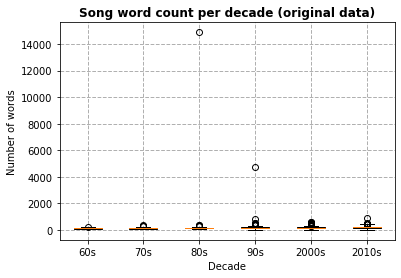

In [90]:
# #PLOT USING MATPLOTLIB

#Create separate subsets per bin
words_2010s=words_count_df.loc[words_count_df["Bin"] == "2010s"]["Words count"]
words_2000s=words_count_df.loc[words_count_df["Bin"] == "2000s"]["Words count"]
words_90s=words_count_df.loc[words_count_df["Bin"] == "90s"]["Words count"]
words_80s=words_count_df.loc[words_count_df["Bin"] == "80s"]["Words count"]
words_70s=words_count_df.loc[words_count_df["Bin"] == "70s"]["Words count"]
words_60s=words_count_df.loc[words_count_df["Bin"] == "60s"]["Words count"]

#plot
fig= plt.plot(figsize=(20,10))
labels=["60s", "70s", "80s", "90s", "2000s", "2010s"]
data=[words_60s, words_70s,words_80s, words_90s, words_2000s, words_2010s]

# rectangular box plot
bplot = plt.boxplot(data,patch_artist=True,  # fill with color,
                    labels=labels)  # will be used to label x-ticks

plt.title("Song word count per decade (original data)", fontsize=12, fontweight="bold")
plt.xlabel("Decade")
plt.ylabel("Number of words")
plt.grid(linestyle='--', linewidth=1)


# fill with colors
#Note: bplot is a dict, these are the keys: ['whiskers', 'caps', 'boxes', 'medians', 'fliers', 'means']
colors=["mediumblue", "cornflowerblue","lightsteelblue", "lightsalmon","indianred", "brown"]


for patch, color in zip(bplot["boxes"], colors):
        patch.set_facecolor(color)


plt.savefig("Plots/word_count_boxplot_original_matplotlib.png")

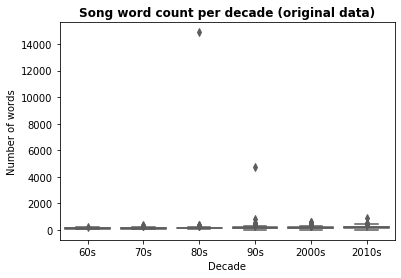

In [66]:
#PLOT USING SEABORN
order=["60s", "70s", "80s", "90s", "2000s", "2010s"]

# Use a color palette
fig=sns.boxplot( x=words_count_df["Bin"], y=words_count_df["Words count"], order=order,palette="coolwarm")
fig.set(xlabel='Decade', ylabel='Number of words')
fig.set_title("Song word count per decade (original data)", fontsize=12, fontweight="bold")
plt.savefig("Plots/word_count_boxplot_original_seaborn.png")

In [14]:
#Identify outliers from words_count_df with number of words >2000
outliers=words_count_df.loc[words_count_df["Words count"] > 2000]
outliers

,Song Name,Artist,Words count,Year,Bin
753,Everybody's Gotta Learn Sometimes,Beck,4723,1999,90s
1022,shhh.. Just listEn :),A Rocket to the Moon,14887,1988,80s


In [15]:
#Retrieve info for outliers in song_list_df
outliers_df=song_list_df.loc[(song_list_df.index == 753) | (song_list_df.index == 1022)]
outliers_df

,Rank,Song Name,Artist,Duration,Album,Lyrics,Year,bins
753,993,Everybody's Gotta Learn Sometimes,Beck,354,Cinematic Treatment,[Verse 1]\nSometimes you can fix something by ...,1999,90s
1022,774,shhh.. Just listEn :),A Rocket to the Moon,0,NaN,"FADE IN:\n\nEXT. WINTER RIVER, CONNECTICUT - D...",1988,80s


### Check outliers lyrics

In [16]:
#A Rocket to the Moon - shhh.. Just listEn :)
outliers_df["Lyrics"][1022]

#Comment: A lot info in the lyrics, like " CAMERA EXPLORES, ATTIC - NEW ANGLE - DAY" -----> DROP!

'FADE IN:\n\nEXT. WINTER RIVER, CONNECTICUT - DAY\n\nA crisp and perfect New England town.  Almost too neat\nto be real.  No visible townspeople.  CAMERA EXPLORES\ntown.\n\n\nCAMERA FLIES\n\nover a rickety bridge -- PAST the Maitland Hardware and\nAppliance store -- PAST the church -- the Historical\nSociety -- UP over the graveyard on the hill and\nfinally --\n\nTo the Maitland house.  The perfect Victorian house\nsurveying the tiny village.  Suddenly --\n\n\nA GIANT DADDY LONGLEGS SPIDER\n\nmounts the crest of the hill beside the house, pauses to\nwave a spindly leg and then creeps menacingly on top of\nthe Maitland house.\n\nADAM (O.S..)\nWell, well, you\'re a big fella...!\n\nA hand -- as big as God\'s -- with a huge tweezer,\ngently reaches down out of the sky and lies, palm up,\nin the yard next to the house.  Daddy Longlegs climbs\ninto it.  The hand rises into the sky again.\n\n\nINT. ATTIC - NEW ANGLE - DAY\n\nReveals Winter River as a miniature town, while The\nDaddy Longlegs

In [17]:
#Beck - Everybody's Gotta Learn Sometimes
outliers_df["Lyrics"][753]

#Comment: the song does exist but the lyrics belong to another song (Genius problem) (The Devil Glitch by Chris Butler\
#also known as the longest song ever! Full version is 1h long. https://www.youtube.com/watch?v=10SnNfxjAI8)  -----> DROP!

'[Verse 1]\nSometimes you can fix something by just being a prick\nWinning by intimidation\n\n[Verse 2]\nSometimes you can fix something by just lifting your skirt\nIt\'s the ultimate distraction\n\n[Verse 3]\nI poke button\nI want action\nLet\'s hear some gears and see some smoke\nNo dilly-dally\nMove your heinie\nThis is the age of "go for broke"\n\n[Screw It, There Are 500 Verses, I Don\'t Have Time For This]\nSometimes you can fix something by just kissing some ass\nIf you don\'t mind humiliation\nSometimes you can fix something by just smoking a pipe\nAcademic contemplation\n\n\n\nSo pathetic\n\nNo mechanic\n\nNo steady eye, no magic touch\n\nNo screwdriver\n\nBall-peen hammer\n\nAnd Mr. Fix-it\'s gone to lunch\n\n\n\nNot personal?\n\nYeah it\'s personal\n\nWhat did I ever do to you?\n\nNo crap from\n\nContraptions\n\nJust do what I tell you to do\n\n\n\nSometimes you can fix something by just blaming your mom\n\nEverybody loves a victim\n\nSometimes you can fix something by just 

In [18]:
#Drop outliers
words_count_clean_df=words_count_df.drop([753, 1022])
words_count_clean_df

,Song Name,Artist,Words count,Year,Bin
0,The Scientist,Coldplay,125,2002,2000s
1,Yellow,Coldplay,136,2000,2000s
2,Fix You,Coldplay,133,2005,2000s
3,Chasing Cars,Snow Patrol,112,2006,2000s
4,I'm Yours,Jason Mraz,280,2008,2000s
...,...,...,...,...,...
1105,Hard to Say I'm Sorry,Chicago,131,1983,80s
1106,Haunted,Taylor Swift,233,2010,2010s
1107,Breakthrough,Modest Mouse,136,1996,90s
1108,Saturday Night,Misfits,151,1999,90s


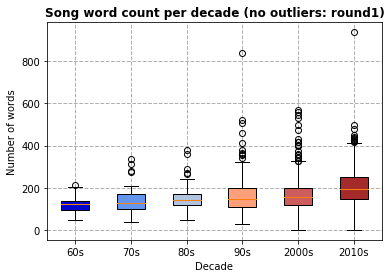

In [91]:
#PLOT USING MATPLOTLIB

#Create separate subsets per bin
words_2010s=words_count_clean_df.loc[words_count_clean_df["Bin"] == "2010s"]["Words count"]
words_2000s=words_count_clean_df.loc[words_count_clean_df["Bin"] == "2000s"]["Words count"]
words_90s=words_count_clean_df.loc[words_count_clean_df["Bin"] == "90s"]["Words count"]
words_80s=words_count_clean_df.loc[words_count_clean_df["Bin"] == "80s"]["Words count"]
words_70s=words_count_clean_df.loc[words_count_clean_df["Bin"] == "70s"]["Words count"]
words_60s=words_count_clean_df.loc[words_count_clean_df["Bin"] == "60s"]["Words count"]

#plot
fig= plt.plot(figsize=(20,10))
labels=["60s", "70s", "80s", "90s", "2000s", "2010s"]
data=[words_60s, words_70s,words_80s, words_90s, words_2000s, words_2010s]

# rectangular box plot
bplot = plt.boxplot(data,patch_artist=True,  # fill with color,
                    labels=labels)  # will be used to label x-ticks

plt.title("Song word count per decade (no outliers: round1)", fontsize=12, fontweight="bold")
plt.xlabel("Decade")
plt.ylabel("Number of words")
plt.grid(linestyle='--', linewidth=1)


# fill with colors
#Note: bplot is a dict, these are the keys: ['whiskers', 'caps', 'boxes', 'medians', 'fliers', 'means']
colors=["mediumblue", "cornflowerblue","lightsteelblue", "lightsalmon","indianred", "brown"]


for patch, color in zip(bplot["boxes"], colors):
        patch.set_facecolor(color)


plt.savefig("Plots/word_count_boxplot_no_outliers_round1_matplotlib.png")

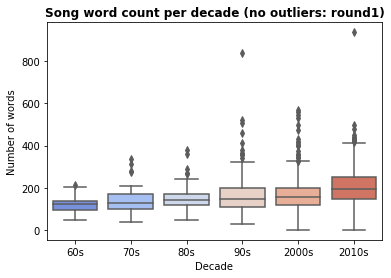

In [65]:
#PLOT USING SEABORN
order=["60s", "70s", "80s", "90s", "2000s", "2010s"]

# Use a color palette
fig=sns.boxplot( x=words_count_clean_df["Bin"], y=words_count_clean_df["Words count"], order=order,palette="coolwarm")
fig.set(xlabel='Decade', ylabel='Number of words')
fig.set_title("Song word count per decade (no outliers: round1)", fontsize=12, fontweight="bold")
plt.savefig("Plots/word_count_boxplot_no_outliers_round1_seaborn.png")

## Check outliers: round 2

In [20]:
#Identify outliers from words_count_df with number of words >600
outliers_2=words_count_clean_df.loc[words_count_clean_df["Words count"] > 600] 
outliers_2

,Song Name,Artist,Words count,Year,Bin
551,"Love Me Like You Do - From ""Fifty Shades of Grey""",Ellie Goulding,936,2015,2010s
990,Brown Skin Lady,Black Star,836,1998,90s


In [21]:
#Retrieve info for outliers in song_list_df
outliers_2_df=song_list_df.loc[(song_list_df.index == 551) | (song_list_df.index == 990)]
outliers_2_df

,Rank,Song Name,Artist,Duration,Album,Lyrics,Year,bins
551,523,"Love Me Like You Do - From ""Fifty Shades of Grey""",Ellie Goulding,0,"Love Me Like You Do (From ""Fifty Shades of Grey"")",Song of the Year\nKendrick Lamar - Alright\nTa...,2015,2010s
990,704,Brown Skin Lady,Black Star,346,Mos Def & Talib Kweli Are Black Star,[Sample: Chameleon Street]\nSmooth: You got th...,1998,90s


In [22]:
#Ellie Goulding - Love Me Like You Do - From "Fifty Shades of Grey"
outliers_2_df["Lyrics"][551]

#Comment: lyrics match from Genius is list of 2016 Grammys Nominees (https://genius.com/Grammys-2016-nominees-lyrics)
# ----> DROP

'Song of the Year\nKendrick Lamar - Alright\nTaylor Swift - Blank Space\nLittle Big Town - Girl Crush\nWiz Khalifa - See You Again ft. Charlie Puth\nEd Sheeran - Thinking Out Loud - WINNER\nRecord of the Year\nD\'Angelo & The Vanguard - Really Love\nMark Ronson - Uptown Funk ft. Bruno Mars - WINNER\nEd Sheeran - Thinking Out Loud\nTaylor Swift - Blank Space\nThe Weeknd - Can\'t Feel My Face\nAlbum of the Year\nAlabama Shakes - Sound & Color\nKendrick Lamar - To Pimp A Butterfly\nChris Stapleton - Traveller\nTaylor Swift - 1989 - WINNER\nThe Weeknd - Beauty Behind The Madness\nBest New Artist\nCourtney Barnett\nJames Bay\nSam Hunt\nTori Kelly\nMeghan Trainor - WINNER\nBest Rap Performance:\nJ. Cole - "Apparently"\nDrake - "Back to Back"\nFetty Wap - "Trap Queen"\nKendrick Lamar - "Alright" - WINNER\nNicki Minaj - "Truffle Butter" ft. Drake & Lil\' Wayne\nKanye West - "All Day" ft. Theophilus London\nBest Rap/Sung Collaboration:\nBig Sean - "One Man Can Change the World" ft. Kanye West &

In [23]:
#Black Star - Brown Skin Lady"
outliers_2_df["Lyrics"][990]

#Comment: Song really has long lyrics, both members of the band (Talib Kweli and Mos Def) sing at the same time 
#(https://genius.com/Black-star-brown-skin-lady-lyrics)  ----> Could keep but it's indeed an outlier

'[Sample: Chameleon Street]\nSmooth: You got that good hair too\nWilliam Douglas Street: You like what?\nSmooth: I like girls with that light complexion on them\nStreet: You\'re a moron\nSmooth: I can\'t help it\nStreet: What? Being a moron\nSmooth: Yeah that too\nStreet: You\'re the first one out there with a dashiki talking that crap\nSmooth: I\'m a victim -\nStreet: "Good hair." Nigga you so brainwashed\nSmooth: I\'m a victim brother\nStreet: You\'re a \'victim\'\nSmooth: I\'m a victim of 400 years of conditioning\nStreet: Shut up\nSmooth: The Man has programmed my conditioning\nStreet: Mhm\nSmooth: Even my conditioning has been conditioned\n\n[Intro: Talib Kweli & Mos Def]\nBut most of yall brothers\nCame from your mothers\nLooking all sweet (Black Star keep shining)\nAnd be like yo, let me ask you somethin\nI wanna know, I wanna know who you are\n\n[Chorus: Mos Def & Talib Kweli]\nBrown skin lady, hey hey\nYes\nWhere you goin\'\nThis goes to the brown skin ladies yo\nBrown skin la

In [24]:
#Drop outliers and save df
words_count_clean_2_df=words_count_clean_df.drop([551, 990])

words_count_clean_2_df.to_csv("csv/song_list_nooutliers.csv")
words_count_clean_2_df

,Song Name,Artist,Words count,Year,Bin
0,The Scientist,Coldplay,125,2002,2000s
1,Yellow,Coldplay,136,2000,2000s
2,Fix You,Coldplay,133,2005,2000s
3,Chasing Cars,Snow Patrol,112,2006,2000s
4,I'm Yours,Jason Mraz,280,2008,2000s
...,...,...,...,...,...
1105,Hard to Say I'm Sorry,Chicago,131,1983,80s
1106,Haunted,Taylor Swift,233,2010,2010s
1107,Breakthrough,Modest Mouse,136,1996,90s
1108,Saturday Night,Misfits,151,1999,90s


In [59]:
#Statistical analysis OneWay ANOVA

#create separate subsets per bin
words_2010s=words_count_clean_2_df.loc[words_count_clean_2_df["Bin"] == "2010s"]["Words count"]
words_2000s=words_count_clean_2_df.loc[words_count_clean_2_df["Bin"] == "2000s"]["Words count"]
words_90s=words_count_clean_2_df.loc[words_count_clean_2_df["Bin"] == "90s"]["Words count"]
words_80s=words_count_clean_2_df.loc[words_count_clean_2_df["Bin"] == "80s"]["Words count"]
words_70s=words_count_clean_2_df.loc[words_count_clean_2_df["Bin"] == "70s"]["Words count"]
words_60s=words_count_clean_2_df.loc[words_count_clean_2_df["Bin"] == "60s"]["Words count"]

#run OneWay ANOVA
(statistic, pvalue)=stats.f_oneway(words_2010s, words_2000s, words_90s, words_80s, words_70s, words_60s)
pvalue

1.754708705023566e-19

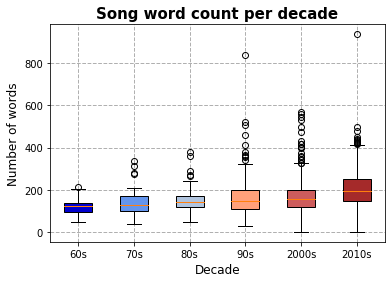

In [87]:
#PLOT USING MATPLOTLIB
fig= plt.plot(figsize=(20,10))
labels=["60s", "70s", "80s", "90s", "2000s", "2010s"]
data=[words_60s, words_70s,words_80s, words_90s, words_2000s, words_2010s]

# rectangular box plot
bplot = plt.boxplot(data,patch_artist=True,  # fill with color,
                    labels=labels)  # will be used to label x-ticks

plt.title("Song word count per decade", fontsize=15, fontweight="bold")
plt.xlabel("Decade", fontsize=12)
plt.ylabel("Number of words", fontsize=12)
plt.grid(linestyle='--', linewidth=1)

# fill with colors
#Note: bplot is a dict, these are the keys: ['whiskers', 'caps', 'boxes', 'medians', 'fliers', 'means']
colors=["mediumblue", "cornflowerblue","lightsteelblue", "lightsalmon","indianred", "brown"]


for patch, color in zip(bplot["boxes"], colors):
        patch.set_facecolor(color)

plt.savefig("Plots/word_count_boxplot_final_matplotlib.png")

The OneWay ANOVA pvalue is: 1.754708705023566e-19


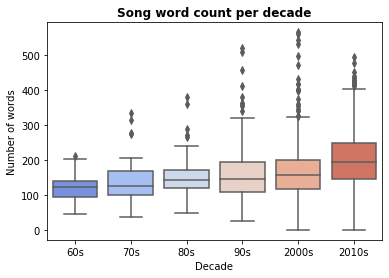

In [67]:
#PLOT USING SEABORN

order=["60s", "70s", "80s", "90s", "2000s", "2010s"]

# Use a color palette
fig=sns.boxplot( x=words_count_clean_2_df["Bin"], y=words_count_clean_2_df["Words count"], order=order,palette="coolwarm")
fig.set(xlabel='Decade', ylabel='Number of words')
fig.set_title("Song word count per decade", fontsize=12, fontweight="bold")
plt.savefig("Plots/word_count_boxplot_final_seaborn.png")
print(f'The OneWay ANOVA pvalue is: {pvalue}')

### Question: is there a correlation between number of words and number of songs in a decade?

The correlation coefficient is: 0.8106293946528845


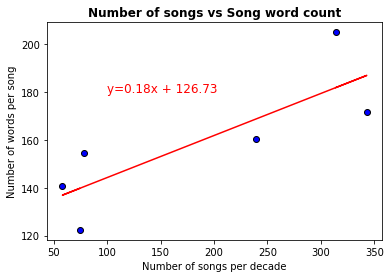

In [69]:
#Scatter Plot
x_values=[len(words_60s), len(words_70s),len(words_80s), len(words_90s), len(words_2000s), len(words_2010s)]
y_values=[words_60s.mean(), words_70s.mean(),words_80s.mean(), words_90s.mean(), words_2000s.mean(), words_2010s.mean()]

plt.scatter(x_values, y_values, marker= "o", c="blue", edgecolors= "black")
plt.title("Number of songs vs Song word count", fontsize=12, fontweight="bold")
plt.xlabel("Number of songs per decade")
plt.ylabel("Number of words per song")



#linear regression
(slope, intercept, rvalue, pvalue, stdev)= stats.linregress(x_values, y_values)
print(f'The correlation coefficient is: {rvalue}')


x_series=pd.Series(x_values)
regress_values= x_series*slope + intercept
line_eq= f'y={str(round(slope, 2))}x + {str(round(intercept,2))}'

plt.plot(x_values, regress_values, "r-")
plt.annotate(line_eq, (100,180), fontsize=12, color= "red")

plt.savefig("Plots/correlation_songwords_songnumber")